In [1]:
import numpy as np
from mixed import MixAgent
from buffer import MultiAgentReplayBuffer
from OrangeEnv import MultiAgentEnv
import matplotlib.pyplot as plt
import pandas as pd
import os


In [2]:
np.random.seed(0)#保证生成的网络一致

In [3]:
scenario = "lattice" #博弈所处的环境，一共分为lattice,ba,random,ws四种。
n_agents = 400 #智能体的总数。
AI_rate = 0.9  #智能体为强化学习者的比例。

N_GAMES = 1  #一局演化重复的次数。
MAX_STEPS = 3000 #一次演化最多会有多少步

evaluate = True  #控制训练的开关。

init_prob = 0.5
spatial_distirbution_list = np.arange(10) * MAX_STEPS / 10

In [4]:
env = MultiAgentEnv(n_agents, scenario)  #生成强化学习环境
actor_dims = []

#waiting for adjustment  
for i in range(n_agents):
    actor_dims.append(env.observation_space[i] * 2)
critic_dims = n_agents * 2

n_actions= 2

In [5]:
#这两个依然有超参数，不过是关于网络结构的，不重要
maddpg_agents = MixAgent(actor_dims, critic_dims, n_agents, n_actions, 
                           fc1=64, fc2=64, AI_rate=AI_rate, 
                           alpha=0.01, beta=0.01, scenario=scenario,
                           chkpt_dir='tmp/mixed/')
memory = MultiAgentReplayBuffer(100000 , critic_dims, actor_dims, 
                        n_actions, n_agents, batch_size=1024 )

In [6]:
#此部分代码的用意是保证训练中断后能继续运行
if os.path.exists('tmp/mixed/' +scenario+ "/" + "agent_" + str(n_agents -1) + "_target_critic" ):
    if os.path.exists('tmp/mixed/' +scenario+ "/" + "agent_" + str(n_agents) + "_target_critic" ):
        for filename in os.listdir('tmp/mixed/' +scenario+ "/"):
            os.remove('tmp/mixed/' +scenario+ "/" + filename)
    else:
        maddpg_agents.load_checkpoint()

... loading checkpoint ...


In [7]:
#variable for counting, which is not need to adjust.
total_steps = 0
score_history = []
best_score = 0
PRINT_INTERVAL = 100 

In [8]:
#如果不需要训练，则为测试模式。
if evaluate:
    maddpg_agents.load_checkpoint()

... loading checkpoint ...


In [9]:
# #此部分代码的用意是生成人群最初的策略以及进行一次博弈，以init_prob 为分割点，
# actions = np.zeros([n_agents,2])
# split = int(init_prob * n_agents)
# actions[:split , 0 ] = 1.0
# actions[split:,1 ] = 1.0
# state_, obs_, reward, done, info = env.step(np.array(actions)[:,0])

In [11]:
for i in range(N_GAMES): #默认N_GAMES为1， 因为不需要很多次
    state, obs = env.reset(init_prob)
    score = 0
    done = [False]*n_agents
    episode_step = 0
    cooperate_counts = [init_prob]
    
    #初始化
    actions = np.zeros([n_agents,2])
    split = int(init_prob * n_agents)
    actions[:split , 0 ] = 1.0
    actions[split:,1 ] = 1.0
    _, _, reward, _, _ = env.step(np.array(actions)[:,0])
    
    
    #主循环 
    while not any(done):
        # if evaluate:
        #     env.render()
            #time.sleep(0.1) # to slow down the action for the video
            
        #获取在不同时刻的博弈空间分布
        if episode_step in spatial_distirbution_list:
            spatial_distirbution = pd.DataFrame(np.array(actions)[:,0].reshape(int(np.sqrt(n_agents)),-1))
            spatial_distirbution.to_csv('results/spatial_distribution/' + scenario + '/' 
                                        + scenario 
                                        + ", evaluate = " + str(evaluate) 
                                        + ", Agents_num = "+ str(n_agents) 
                                        + (', AI-rate = %.2f' % AI_rate) 
                                        + (", eposide= %d" % episode_step)
                                        + " .csv"  , index= False, header= None)
        
           
        actions = maddpg_agents.choose_action(obs,reward,actions)
        state_, obs_, reward, done, info = env.step(np.array(actions)[:,0])
        cooperate_count = np.count_nonzero(np.array(actions)[:,0] == 0)
        # state = obs_list_to_state_vector(obs)
        # state_ = obs_list_to_state_vector(obs_)
        cooperate_counts.append(cooperate_count / n_agents) #计算合作率

        if episode_step >= MAX_STEPS-2:
            done = [True]*n_agents 

        memory.store_transition(obs, state, actions, reward, obs_, state_, done)

        if total_steps % 100 == 0 and not evaluate:
            maddpg_agents.learn(memory)

        obs = obs_
        state = state_
        
        score = sum(reward)
        total_steps += 1
        episode_step += 1

    
    #循环过后的数据存储
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    if not evaluate:
        if avg_score > best_score:
            maddpg_agents.save_checkpoint()
            best_score = avg_score
    if i % PRINT_INTERVAL == 0 and i > 0:
        print('episode', i, 'average score {:.1f}'.format(avg_score))

f:\PYTHON PROGRAM\Orange-MARL-v2.01\networks.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = T.tensor(state,dtype= T.float32)


In [12]:
results = pd.Series(cooperate_counts)
if os.path.exists('results/cooperate_counts/' + scenario + '/'+"evaluate = "+ str(evaluate) +", Agents_num = "+ str(n_agents) + (', AI-rate = %.2f' % AI_rate) + " .csv"  ):
    results_last = pd.read_csv('results/cooperate_counts/' + scenario + '/'+"evaluate = "+ str(evaluate) +", Agents_num = "+ str(n_agents) + (', AI-rate = %.2f' % AI_rate) + " .csv"  ,header= None)
    # results_last = pd.Series(results_last)
    results = pd.concat([results_last,results],ignore_index=True)
results.to_csv('results/cooperate_counts/' + scenario + '/'+"evaluate = "+ str(evaluate) +", Agents_num = "+ str(n_agents) + (', AI-rate = %.2f' % AI_rate) + " .csv"  , index= False,header=0)

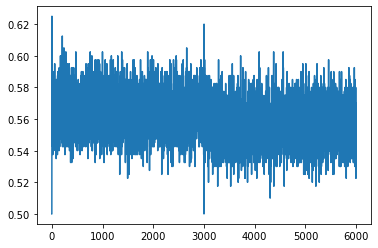

In [13]:
plt.plot(results)